# Transformer Models Advanced Training Guide
This guide is showing advanced features of RecTools transformer models training.

### Table of Contents

* Prepare data
* Advanced training guide
    * Validation fold
    * Validation loss
    * Callback for Early Stopping
    * Callbacks for Checkpoints
        * Loading Checkpoints
    * Callbacks for RecSys metrics
        * RecSys metrics for Early Stopping anf Checkpoints
* Advanced training full example
    * Running full training with all of the described validation features on Kion dataset
* More RecTools features for transformers
    * Saving and loading models
    * Configs for transformer models
        * Classes and function in configs
    * Multi-gpu training


In [1]:
import os
import typing as tp
import warnings

import pandas as pd
import numpy as np
import torch
from lightning_fabric import seed_everything
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import   Callback

from rectools.dataset import Dataset
from rectools.models import  SASRecModel
from rectools.models import HSTUModel
from rectools.models.nn.item_net import IdEmbeddingsItemNet
from rectools import Columns, ExternalIds
from scipy import sparse
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback
# Enable deterministic behaviour with CUDA >= 10.2
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
from rectools.model_selection import LastNSplitter, cross_validate_hstu
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
from rectools.metrics import (
    MAP,
    CoveredUsers,
    AvgRecPopularity,
    Intersection,
    HitRate,
    Serendipity,
)
from rectools.models import PopularModel, EASEModel, SASRecModel, BERT4RecModel
from rectools.model_selection import TimeRangeSplitter, cross_validate
from rectools.models.nn.item_net import CatFeaturesItemNet, IdEmbeddingsItemNet
from rectools.visuals import MetricsApp


In [2]:
import sys
print(sys.executable)

/home/student/kuzin/python_project/RecTools/.venv/bin/python3


In [3]:
import cffi
import zmq  # pyzmq
import notebook  # jupyter

## Prepare data

%%time
!wget -q https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ml-1m.zip
!unzip -o ml-1m.zip
!rm ml-1m.zip

In [4]:
%%time
ratings = pd.read_csv(
    "ml-1m/ratings.dat", 
    sep="::",
    engine="python",  # Because of 2-chars separators
    header=None,
    names=[Columns.User, Columns.Item, Columns.Weight, Columns.Datetime],
)
print(ratings.shape)
ratings[Columns.Weight] = 1
ratings.head()

(1000209, 4)
CPU times: user 3.31 s, sys: 150 ms, total: 3.46 s
Wall time: 3.45 s


,user_id,item_id,weight,datetime
0,1,1193,1,978300760
1,1,661,1,978302109
2,1,914,1,978301968
3,1,3408,1,978300275
4,1,2355,1,978824291


In [5]:
ratings[Columns.Datetime] = ratings[Columns.Datetime].astype("datetime64[s]")

In [6]:
nan_count = ratings.isna().sum()
print(f"Количество NaN в колонке '{Columns.Datetime}': {nan_count}")

Количество NaN в колонке 'datetime': user_id     0
item_id     0
weight      0
datetime    0
dtype: int64


In [7]:
dataset = Dataset.construct(ratings)

In [8]:
dataset.interactions.df.shape

(1000209, 4)

In [9]:
RANDOM_STATE=60
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_STATE, workers=True)

Seed set to 60


60

In [10]:
paper_df =   pd.read_csv("sasrec_format.csv")
paper_df.head()

,index,user_id,sequence_item_ids,sequence_ratings,sequence_timestamps,sex,age_group,occupation,zip_code
0,4260,4261,"260,2302,2312,2154,902,2616,745,720,3429,1223,...","5,4,3,3,3,2,5,3,3,5,3,5,3,4,3,5,3,5,5,5,4,3,5,...","965305148,965305148,965305189,965305189,965305...",0,3,6,346
1,4645,4646,"337,2587,409,260,1210,1288,2153,2858,3147,2959...","3,2,2,4,4,2,1,5,4,2,3,4,3,3,4,4,1,1,3,5,5,3,4,...","963968496,963968496,963968496,963968496,963968...",0,2,6,2796
2,990,991,"2670,278,1968,1198,1097,1235,2396,1277,2243,91...","2,3,4,4,2,5,3,3,4,4,3,3,4,3,4,4,4,3,5,3,4,3,5,...","975086183,975086297,975086297,975086414,975086...",0,2,9,1597
3,4261,4262,"1097,1226,1373,858,1081,1173,3751,3770,3763,37...","4,5,4,5,4,2,5,3,3,3,4,5,4,3,4,4,3,4,4,5,4,4,4,...","965305021,965305021,965305046,965305046,965305...",0,3,6,286
4,3297,3298,"1746,2496,1805,1993,1614,3095,2858,2188,2706,2...","3,3,5,2,5,4,5,4,4,3,4,5,5,5,5,4,5,5,4,4,5,5,5,...","968047151,968047191,968047228,968047285,968047...",1,0,10,822


In [11]:
paper_df = paper_df[["index","user_id", "sequence_item_ids", "sequence_ratings", "sequence_timestamps"]]

In [12]:
import pandas as pd
import ast

cols_to_expand = ["sequence_item_ids", "sequence_ratings", "sequence_timestamps"]

# Преобразуем строки в списки
for col in cols_to_expand:
    paper_df[col] = paper_df[col].apply(ast.literal_eval)

# Разбираем на отдельные строки
expanded_df = paper_df[["user_id"] + cols_to_expand]
expanded_df = expanded_df.explode(cols_to_expand)

# Переименовываем
expanded_df = expanded_df.rename(columns={
    "sequence_item_ids": "item_id",
    "sequence_ratings": "rating",
    "sequence_timestamps": "timestamp"
})

# Приводим к правильным типам
expanded_df["item_id"] = expanded_df["item_id"].astype(int)
expanded_df["rating"] = expanded_df["rating"].astype(float)
expanded_df["timestamp"] = expanded_df["timestamp"].astype(int)

# Преобразуем Unix timestamp в datetime
expanded_df["datetime"] = pd.to_datetime(expanded_df["timestamp"], unit="s")

# Убираем временный столбец с timestamp, если не нужен
expanded_df = expanded_df.drop(columns=["timestamp"])

# Сбрасываем индекс
expanded_df.reset_index(drop=True, inplace=True)

In [13]:
expanded_df

,user_id,item_id,rating,datetime
0,4261,260,5.0,2000-08-03 12:19:08
1,4261,2302,4.0,2000-08-03 12:19:08
2,4261,2312,3.0,2000-08-03 12:19:49
3,4261,2154,3.0,2000-08-03 12:19:49
4,4261,902,3.0,2000-08-03 12:19:49
...,...,...,...,...
1000204,5824,2381,2.0,2000-05-10 15:04:25
1000205,5824,473,1.0,2000-05-10 15:04:25
1000206,5824,2799,1.0,2000-05-10 15:04:53
1000207,5824,2382,1.0,2000-05-10 15:05:14


In [14]:
result = expanded_df[["user_id", "item_id", "datetime"]]
result["weight"] = 1
result

,user_id,item_id,datetime,weight
0,4261,260,2000-08-03 12:19:08,1
1,4261,2302,2000-08-03 12:19:08,1
2,4261,2312,2000-08-03 12:19:49,1
3,4261,2154,2000-08-03 12:19:49,1
4,4261,902,2000-08-03 12:19:49,1
...,...,...,...,...
1000204,5824,2381,2000-05-10 15:04:25,1
1000205,5824,473,2000-05-10 15:04:25,1
1000206,5824,2799,2000-05-10 15:04:53,1
1000207,5824,2382,2000-05-10 15:05:14,1


In [15]:
dataset = Dataset.construct(result)

In [16]:
splitter = LastNSplitter(1,1)
train_dataset = None
test_df = None

In [17]:
split_iterator = splitter.split(dataset.interactions, collect_fold_stats=True)

In [18]:
for train_ids, test_ids, split_info in split_iterator:
    
    fold_dataset = dataset.filter_interactions(
        row_indexes_to_keep=train_ids,
        keep_external_ids=True,
    )
    interactions_df_test = dataset.interactions.df.loc[test_ids]
    interactions_df_test[Columns.User] = dataset.user_id_map.convert_to_external(interactions_df_test[Columns.User])
    interactions_df_test[Columns.Item] = dataset.item_id_map.convert_to_external(interactions_df_test[Columns.Item])
    train_dataset = fold_dataset
    test_df  =interactions_df_test 

In [19]:
test_df

,user_id,item_id,weight,datetime
275,4261,1181,1.0,2000-08-03 13:12:40
315,4646,25,1.0,2000-07-19 01:09:55
374,991,955,1.0,2000-11-28 22:10:40
413,4262,673,1.0,2000-08-03 12:23:24
445,3298,3785,1.0,2000-09-04 06:19:22
...,...,...,...,...
997765,2787,3555,1.0,2000-10-31 04:41:43
997811,5591,3535,1.0,2000-09-25 00:19:49
999554,4277,2675,1.0,2003-02-25 17:15:25
999658,4308,1824,1.0,2000-08-03 00:16:48


### Validation fold

Models do not create validation fold during `fit` by default. However, there is a simple way to force it.

Let's assume that we want to use Leave-One-Out validation for specific set of users. To apply it we need to implement `get_val_mask_func` with required logic and pass it to model during initialization.

This function should receive interactions with standard RecTools columns and return a binary mask which identifies interactions that should not be used during model training. But instrad should be used for validation loss calculation. They will also be available for Lightning Callbacks to allow RecSys metrics computations.

*Please make sure you do not use `partial` while doing this. Partial functions cannot be by serialized using RecTools.*

In [20]:
# Implement `get_val_mask_func`

unique_users = ratings[Columns.User].unique()
VAL_USERS = unique_users

def leave_one_out_mask_for_users(interactions: pd.DataFrame, val_users: ExternalIds) -> np.ndarray:
    rank = (
        interactions
        .sort_values(Columns.Datetime, ascending=False, kind="stable")
        .groupby(Columns.User, sort=False)
        .cumcount()
    )
    val_mask = (
        (interactions[Columns.User].isin(val_users))
        & (rank == 0)
    )
    return val_mask.values

# We do not use `partial` for correct serialization of the model
def get_val_mask_func(interactions: pd.DataFrame):
    return leave_one_out_mask_for_users(interactions, val_users = VAL_USERS)

In [21]:
class RecallCallback(Callback):  # with filter
    name: str = "recall"

    def __init__(self, k: int, prog_bar: bool = True) -> None:
        self.k = k
        self.name += f"@{k}"
        self.prog_bar = prog_bar

        self.batch_recall_per_users: tp.List[torch.Tensor] = []

    def on_validation_batch_end(
        self,
        trainer: Trainer,
        pl_module: LightningModule,
        outputs: tp.Dict[str, torch.Tensor],
        batch: tp.Dict[str, torch.Tensor],
        batch_idx: int,
        dataloader_idx: int = 0,
    ) -> None:

        if "logits" not in outputs:
            session_embs = pl_module.torch_model.encode_sessions(
                batch, pl_module.item_embs
            )[:, -1, :]
            logits = pl_module.torch_model.similarity_module(
                session_embs, pl_module.item_embs
            )
        else:
            logits = outputs["logits"]

        x = batch["x"]
        users = x.shape[0]
        row_ind = np.arange(users).repeat(x.shape[1])
        col_ind = x.flatten().detach().cpu().numpy()
        mask = col_ind != 0
        data = np.ones_like(row_ind[mask])
        filter_csr = sparse.csr_matrix(
            (data, (row_ind[mask], col_ind[mask])),
            shape=(users, pl_module.torch_model.item_model.n_items),
        )
        mask = torch.from_numpy((filter_csr != 0).toarray()).to(logits.device)
        scores = torch.masked_fill(logits, mask, float("-inf"))

        _, batch_recos = scores.topk(k=self.k)

        targets = batch["y"]

        # assume all users have the same amount of TP
        liked = targets.shape[1]
        tp_mask = torch.stack(
            [
                torch.isin(batch_recos[uid], targets[uid])
                for uid in range(batch_recos.shape[0])
            ]
        )
        recall_per_users = tp_mask.sum(dim=1) / liked

        self.batch_recall_per_users.append(recall_per_users)

    def on_validation_epoch_end(
        self, trainer: Trainer, pl_module: LightningModule
    ) -> None:
        recall = float(torch.concat(self.batch_recall_per_users).mean())
        self.log_dict(
            {self.name: recall}, on_step=False, on_epoch=True, prog_bar=self.prog_bar
        )

        self.batch_recall_per_users.clear()

In this guide we are going to use custom Lighhning trainers. We need to implement function that return desired Lightining trainer and pass it to model during initialization.

In [22]:

# Callback for calculating RecSys metrics
recall_callback = RecallCallback(k=10, prog_bar=True)

In [23]:
# Checkpoint last epoch
last_epoch_ckpt = ModelCheckpoint(filename="last_epoch")

# Checkpoints based on validation loss
least_val_loss_ckpt = ModelCheckpoint(
    monitor="val_loss",   # or just pass "val_loss" here,
    mode="min",
    filename="{epoch}-{val_loss:.2f}",
    save_top_k=2,  # Let's save top 2 checkpoints for validation loss
)

In [24]:
# Function to get custom trainer

def get_debug_trainer() -> Trainer:
    return Trainer(
        accelerator="gpu",
        devices=1,
        min_epochs=2,
        max_epochs=2,
        limit_train_batches=2,
        deterministic=True,
        enable_model_summary=False,
        enable_progress_bar=True,
        callbacks=[recall_callback, last_epoch_ckpt, least_val_loss_ckpt],  # pass our callbacks
        logger = CSVLogger("test_logs"),  # We use CSV logging for this guide but there are many other options
    )

In [25]:
session_max_len = 200
extra_cols_kwargs =  {"extra_cols_kwargs": {"extra_cols": [Columns.Datetime]}}
transformer_layers_kwargs = {
    "attention_dim": 50,
    "linear_hidden_dim":50,
    "attn_dropout_ratio": 0.1,
    "session_max_len": session_max_len,
    "attention_mode" : "rel_pos_ts_bias"
}
lightning_module_kwargs = {
    "temperature": 0.05
}
model  = HSTUModel(session_max_len = session_max_len,
    data_preparator_kwargs=extra_cols_kwargs,
    transformer_layers_kwargs=transformer_layers_kwargs,
    lightning_module_kwargs=lightning_module_kwargs,
    item_net_block_types=(IdEmbeddingsItemNet,),
    get_val_mask_func=get_val_mask_func,  # pass our custom `get_val_mask_func`
    get_trainer_func=get_debug_trainer,  # pass our custom trainer func
    verbose=1,
    loss = 'sampled_softmax',
    n_negatives= 128,
    use_pos_emb = True,
    dropout_rate = 0.2,
    n_factors = 50,
    n_heads = 1,
    n_blocks = 2,
    lr = 0.001,
    batch_size=128,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


{'extra_cols': ['datetime']}


### Validation loss

Let's check how the validation loss is being logged.

In [26]:
# Fit model. Validation fold and validation loss computation will be done under the hood.

model.fit(train_dataset)

кол-во айтемов 3646
{'extra_cols': ['datetime']}


You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


item_model.item_net_blocks.0.ids_emb.weight torch.Size([3646, 50])
pos_encoding_layer.pos_emb.weight torch.Size([200, 50])
transformer_layers.stu_blocks.0._uvqk torch.Size([50, 200])
transformer_layers.stu_blocks.0._rel_attn_bias._ts_w torch.Size([129])
transformer_layers.stu_blocks.0._rel_attn_bias._pos_w torch.Size([401])
transformer_layers.stu_blocks.0._o.weight torch.Size([50, 50])
transformer_layers.stu_blocks.0._o.bias torch.Size([50])
transformer_layers.stu_blocks.1._uvqk torch.Size([50, 200])
transformer_layers.stu_blocks.1._rel_attn_bias._ts_w torch.Size([129])
transformer_layers.stu_blocks.1._rel_attn_bias._pos_w torch.Size([401])
transformer_layers.stu_blocks.1._o.weight torch.Size([50, 50])
transformer_layers.stu_blocks.1._o.bias torch.Size([50])
transformer_layers.last_layernorm.weight torch.Size([50])
transformer_layers.last_layernorm.bias torch.Size([50])


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [27]:
!ls $model.fit_trainer.log_dir/checkpoints
ckpt_path = os.path.join(model.fit_trainer.log_dir, "checkpoints", "last_epoch.ckpt")
model.load_weights_from_checkpoint(ckpt_path)

'epoch=0-val_loss=4.91.ckpt'  'epoch=1-val_loss=4.87.ckpt'   last_epoch.ckpt


Инвариант - всегда надо клеить думми с таймстемпом. Откуда брать таймстемпы? В случае тестирования на последнем - передаём тестовый датафрейм, дёргаем строки с  "users=[20]", оттуда берём таймстемпы. В случае инференса передавать таймстемпы отдельно, поэтому напишем враппер, который обрабатывает два этих случая, а 

In [28]:
ErrorBehaviour = tp.Literal["ignore", "warn", "raise"]

In [29]:
user_test_id = 20

In [30]:
def proxy_recommend(
        model,
        users: ExternalIds,
        dataset: Dataset,
        k: int,
        filter_viewed: bool,
        items_to_recommend: tp.Optional[ExternalIds] = None,
        add_rank_col: bool = True,
        on_unsupported_targets: ErrorBehaviour = "raise",
        df_test = None, 
        df_timestamp = None,
    ) -> pd.DataFrame:
    #Логично,что df_test и df_timestamp придут во внешней индексации, потребуем тем не менее совпадения колонок с interactions
    #ожидаю, что df_test лоо на последних айтемах, на каждего юзера по одному тесту, поэтому подклейка будет просто конкатенацией
    dataset_recommend = dataset
    
    model_known_external_ids = model.data_preparator.get_known_item_ids()
    dummy_common_item = np.intersect1d(dataset_recommend.item_id_map.external_ids, model_known_external_ids)[0]
    if df_test is not None:
        print(f"common dummy id:{dummy_common_item}")
        in_external_view_dataset_recommend =  dataset_recommend.get_raw_interactions()
        in_external_view_dataset_test =  df_test.copy()
        in_external_view_dataset_test[Columns.Item] = dummy_common_item
        
        union = pd.concat([in_external_view_dataset_recommend, in_external_view_dataset_test])
        new_dataset_recommend = Dataset.construct(union)
        return model.recommend(users,new_dataset_recommend,k,filter_viewed,items_to_recommend,add_rank_col,on_unsupported_targets)
    if df_timestamp is not None:
        pass
    
    return model.recommend(users = users,dataset = dataset_recommend,k=k,filter_viewed= filter_viewed,items_to_recommend = items_to_recommend,add_rank_col = add_rank_col,on_unsupported_targets = on_unsupported_targets)
    

In [31]:
print(test_df[test_df[Columns.User] == user_test_id])

        user_id  item_id  weight            datetime
756318       20     1371     1.0 2001-12-29 23:40:27


In [32]:
proxy_recommend(model,users = [20], dataset=train_dataset, k =5,filter_viewed = True,  df_test=test_df)

common dummy id:1


,user_id,item_id,score,rank
0,20,1833,0.088064,1
1,20,1393,0.080983,2
2,20,1729,0.073374,3
3,20,523,0.071480,4
4,20,3552,0.068110,5


Timestamp('2001-12-29 23:40:27') последний, сходится

In [33]:
model.recommend(users = [20], dataset=train_dataset, k =5,filter_viewed = True)

,user_id,item_id,score,rank
0,20,1393,0.088753,1
1,20,1729,0.072086,2
2,20,1833,0.069273,3
3,20,3621,0.068033,4
4,20,3131,0.067266,5


### Боевая кросс-валидация

In [34]:
set(dataset.interactions.df.user_id.unique()) == set(dataset.item_id_map.external_ids) #

False

In [35]:
def get_debug_trainer() -> Trainer:
    return Trainer(
        accelerator="gpu",
        devices=1,
        min_epochs=120,
        max_epochs=120,
        deterministic=True,
        enable_model_summary=False,
        #enable_progress_bar=True,
        callbacks=[recall_callback, last_epoch_ckpt, least_val_loss_ckpt],  # pass our callbacks
        logger = CSVLogger("test_logs"),  # We use CSV logging for this guide but there are many other options
    )

In [36]:
model_hstu  = HSTUModel(session_max_len = session_max_len,
    data_preparator_kwargs=extra_cols_kwargs,
    transformer_layers_kwargs=transformer_layers_kwargs,
    lightning_module_kwargs=lightning_module_kwargs,
    item_net_block_types=(IdEmbeddingsItemNet,),
    get_val_mask_func=get_val_mask_func,  # pass our custom `get_val_mask_func`
    get_trainer_func=get_debug_trainer, 
    verbose=1,
    loss = 'sampled_softmax',
    n_negatives= 128,
    use_pos_emb = True,
    dropout_rate = 0.2,
    n_factors = 50,
    n_heads = 1,
    n_blocks = 2,
    lr = 0.001,
    batch_size=128,
)
model_sasrec  = SASRecModel(session_max_len = session_max_len,
    item_net_block_types=(IdEmbeddingsItemNet,),
    get_val_mask_func=get_val_mask_func,  # pass our custom `get_val_mask_func`
    get_trainer_func=get_debug_trainer,  # pass our custom trainer func
    verbose=1,
    lightning_module_kwargs=lightning_module_kwargs,
    use_pos_emb = True,
    loss = 'sampled_softmax',
    n_negatives= 128,
    dropout_rate = 0.2,
    n_factors = 50,
    n_heads = 1,
    n_blocks = 2,
    lr = 0.001,
    batch_size=128,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


{'extra_cols': ['datetime']}
None


In [37]:
#model._trainer = trainer

In [38]:
models = {
    "sasrec": model_sasrec,
    "hstu": model_hstu,
}

metrics = {
    "HitRate@10": HitRate(k=10),
    "MAP@10": MAP(k=10),
    "Serendipity@10": Serendipity(k=10),
    "CoveredUsers@10": CoveredUsers(k=10),  # how many test users received recommendations
    "AvgRecPopularity@10": AvgRecPopularity(k=10),  # average popularity of recommended items
}

K_RECS = 10

In [39]:
cv_results = cross_validate_hstu(
    proxy_recommend=proxy_recommend,
    dataset=dataset,
    splitter=splitter,
    models=models,
    metrics=metrics,
    k=K_RECS,
    filter_viewed=True,
)

sasrec
кол-во айтемов 3646
None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


item_model.item_net_blocks.0.ids_emb.weight torch.Size([3646, 50])
pos_encoding_layer.pos_emb.weight torch.Size([200, 50])
transformer_layers.transformer_blocks.0.multi_head_attn.in_proj_weight torch.Size([150, 50])
transformer_layers.transformer_blocks.0.multi_head_attn.in_proj_bias torch.Size([150])
transformer_layers.transformer_blocks.0.multi_head_attn.out_proj.weight torch.Size([50, 50])
transformer_layers.transformer_blocks.0.multi_head_attn.out_proj.bias torch.Size([50])
transformer_layers.transformer_blocks.0.q_layer_norm.weight torch.Size([50])
transformer_layers.transformer_blocks.0.q_layer_norm.bias torch.Size([50])
transformer_layers.transformer_blocks.0.ff_layer_norm.weight torch.Size([50])
transformer_layers.transformer_blocks.0.ff_layer_norm.bias torch.Size([50])
transformer_layers.transformer_blocks.0.feed_forward.ff_linear_1.weight torch.Size([50, 50])
transformer_layers.transformer_blocks.0.feed_forward.ff_linear_1.bias torch.Size([50])
transformer_layers.transformer_

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=120` reached.


кол-во айтемов 3646
{'extra_cols': ['datetime']}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


item_model.item_net_blocks.0.ids_emb.weight torch.Size([3646, 50])
pos_encoding_layer.pos_emb.weight torch.Size([200, 50])
transformer_layers.stu_blocks.0._uvqk torch.Size([50, 200])
transformer_layers.stu_blocks.0._rel_attn_bias._ts_w torch.Size([129])
transformer_layers.stu_blocks.0._rel_attn_bias._pos_w torch.Size([401])
transformer_layers.stu_blocks.0._o.weight torch.Size([50, 50])
transformer_layers.stu_blocks.0._o.bias torch.Size([50])
transformer_layers.stu_blocks.1._uvqk torch.Size([50, 200])
transformer_layers.stu_blocks.1._rel_attn_bias._ts_w torch.Size([129])
transformer_layers.stu_blocks.1._rel_attn_bias._pos_w torch.Size([401])
transformer_layers.stu_blocks.1._o.weight torch.Size([50, 50])
transformer_layers.stu_blocks.1._o.bias torch.Size([50])
transformer_layers.last_layernorm.weight torch.Size([50])
transformer_layers.last_layernorm.bias torch.Size([50])


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=120` reached.


common dummy id:1


In [40]:
cv_results

{'splits': [{'i_split': 0,
   'train': 994169,
   'train_users': 6040,
   'train_items': 3704,
   'test': 6038,
   'test_users': 6038,
   'test_items': 1910}],
 'metrics': [{'model': 'sasrec',
   'i_split': 0,
   'HitRate@10': 0.26018549188473006,
   'MAP@10': 0.11157983564409533,
   'AvgRecPopularity@10': 871.1352268963233,
   'Serendipity@10': 0.0023410856512068637,
   'CoveredUsers@10': 1.0},
  {'model': 'hstu',
   'i_split': 0,
   'HitRate@10': 0.2893342166280225,
   'MAP@10': 0.12439286634384347,
   'AvgRecPopularity@10': 970.5863365352767,
   'Serendipity@10': 0.002492462245948446,
   'CoveredUsers@10': 1.0}]}

In [41]:
pivot_results = (
    pd.DataFrame(cv_results["metrics"])
    .drop(columns="i_split")
    .groupby(["model"], sort=False)
    .agg(["mean"])
)
pivot_results.columns = pivot_results.columns.droplevel(1)
pivot_results.to_csv("rectools_transformers_cv.csv", index=True)
pivot_results

,HitRate@10,MAP@10,AvgRecPopularity@10,Serendipity@10,CoveredUsers@10
model,,,,,
sasrec,0.260185,0.111580,871.135227,0.002341,1.0
hstu,0.289334,0.124393,970.586337,0.002492,1.0


In [43]:
models_metrics = pivot_results.reset_index()[["model", "MAP@10", "Serendipity@10"]]

app = MetricsApp.construct(
    models_metrics=models_metrics,
    scatter_kwargs={
        "symbol_sequence": ['circle', 'square', 'diamond', 'cross', 'x', 'star', 'pentagon'],
    }
)
fig = app.fig
fig.update_layout(title="Model CV metrics", font={"size": 15})
fig.update_traces(marker={'size': 9})
fig.show("png")

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [44]:
def get_logs(model) -> tp.Tuple[pd.DataFrame, ...]:
    log_path = os.path.join(model.fit_trainer.log_dir, "metrics.csv")
    epoch_metrics_df = pd.read_csv(log_path)

    loss_df = epoch_metrics_df[["epoch", "train_loss"]].dropna()
    val_loss_df = epoch_metrics_df[["epoch", "val_loss"]].dropna()
    loss_df = pd.merge(loss_df, val_loss_df, how="inner", on="epoch")
    loss_df.reset_index(drop=True, inplace=True)

    metrics_df = epoch_metrics_df.drop(columns=["train_loss", "val_loss"]).dropna()
    metrics_df.reset_index(drop=True, inplace=True)

    return loss_df, metrics_df

In [49]:
loss_df_hstu, metrics_df_hstu = get_logs(model_hstu)
loss_df_sasrec, metrics_df_sasrec = get_logs(model_sasrec)

In [51]:
metrics_df_hstu

,epoch,recall@10,step
0,0,0.033284,47
1,1,0.037423,95
2,2,0.041894,143
3,3,0.071038,191
4,4,0.080642,239
...,...,...,...
115,115,0.306839,5567
116,116,0.305017,5615
117,117,0.306673,5663
118,118,0.295910,5711


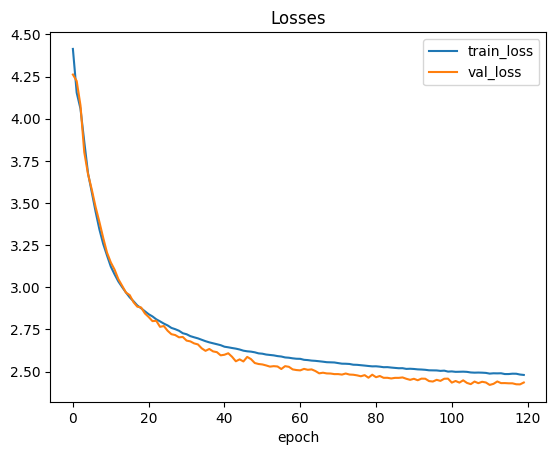

In [50]:
loss_df_hstu.plot(kind="line", x="epoch", title="Losses");

In [ ]:
import seaborn as sns

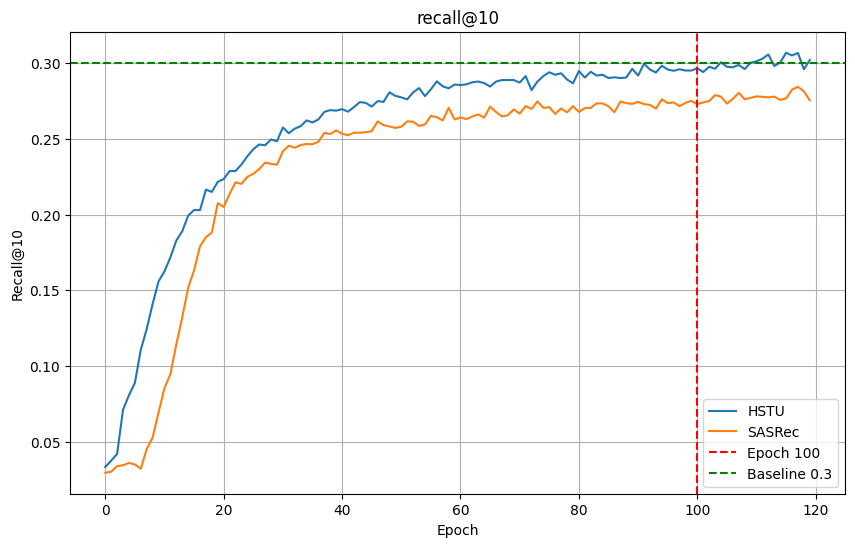

In [56]:
import matplotlib.pyplot as plt

# Создаем график
plt.figure(figsize=(10, 6))

plt.plot(metrics_df_hstu["epoch"], metrics_df_hstu["recall@10"], label="HSTU")
plt.plot(metrics_df_sasrec["epoch"], metrics_df_sasrec["recall@10"], label="SASRec")
plt.axvline(x=100, linestyle='--', color='r', label='Epoch 100')  


plt.axhline(y=0.3, linestyle='--', color='g', label='Baseline 0.3') 
plt.title("recall@10")
plt.xlabel("Epoch")
plt.ylabel("Recall@10")
plt.legend()
plt.grid(True)
plt.show()

In [42]:
assert 1 ==2

SyntaxError: invalid syntax (2328911495.py, line 1)

Let's look at model logs. We can access logs directory with `model.fit_trainer.log_dir`